In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Read data into pandas
japan = pd.read_excel(".././data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel(".././data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel(".././data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel(".././data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel(".././data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel(".././data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel(".././data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel(".././data/Price History_IAU_Gold_Trust.xlsx")

In [3]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [4]:
japan

,Return Japan
Exchange Date,
2024-12-13,-0.009764
2024-12-12,-0.010338
2024-12-11,0.013895
2024-12-10,-0.006082
2024-12-09,-0.007921
...,...
2005-01-07,-0.001894
2005-01-06,-0.007519
2005-01-05,-0.004677


In [5]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [6]:
start_date = '2014-01-31'
end_date = '2015-10-31'
returns = returns[start_date:end_date]
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2014-01-31,0.003951,0.002183,0.002449,-0.003032,-0.008243,-0.002897,-0.006267,0.000829
2014-02-03,-0.012093,0.006482,0.014056,0.005033,-0.011278,-0.022666,-0.022325,0.010771
2014-02-04,-0.047272,-0.002671,-0.009174,-0.009456,-0.003010,0.016147,0.006850,-0.002459
2014-02-05,0.023168,-0.002814,-0.009883,-0.004735,0.003277,-0.003731,-0.001304,0.003287
2014-02-06,-0.008392,-0.002455,-0.003851,0.015813,0.019685,0.033111,0.013342,-0.000819
...,...,...,...,...,...,...,...,...
2015-10-26,0.009653,0.001731,0.005844,0.002280,-0.002652,-0.008133,-0.002300,-0.000889
2015-10-27,-0.005145,0.002737,0.003048,-0.003342,-0.010584,-0.008020,-0.001921,0.002669
2015-10-28,0.000862,-0.005261,-0.002795,-0.010333,0.012294,0.003460,0.011214,-0.007986


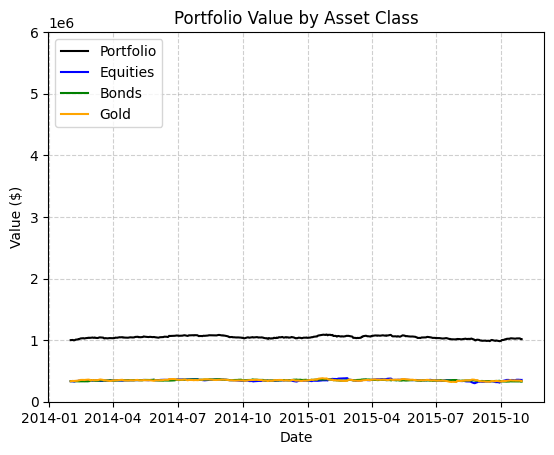

Final Portfolio Value: $1,015,690.57


In [7]:
#### 1/N Portfolio Construction #### v3.0

# Parameters
rebalance_on = True       # Switch for rebalancing
initial_inv = 1_000_000
n_freq = 'ME'             # 'ME' = monthly, 'QE' = quarterly, 'YE' = yearly
tc_rate = 0.001           # Transaction cost rate (0 for pure buy & hold)

# Individual asset weights (for a 1/n portfolio across 8 assets)
weights = {
    'Japan': 1/15,
    'APACxJapan': 1/15,
    'Europe': 1/15,
    'LatAm': 1/15,
    'US': 1/15,
    'T-Bills_7_10': 1/6,
    'T-Bills_20': 1/6,
    'Gold': 1/3,
}
assets = list(weights.keys())

# Determine rebalancing dates (aligned to trading days) if rebalancing is on;
# otherwise, use only the start and end dates.
if rebalance_on:
    reb_dates = returns.resample(n_freq).last().index
    reb_dates = returns.index[returns.index.get_indexer(reb_dates, method='nearest')]
else:
    reb_dates = [returns.index[0], returns.index[-1]]

# Initialize series for overall portfolio value and individual asset values.
port_val = pd.Series(index=returns.index, dtype=float)
port_val.iloc[0] = initial_inv
asset_vals = {asset: pd.Series(index=returns.index, dtype=float) for asset in assets}
for asset in assets:
    asset_vals[asset].iloc[0] = initial_inv * weights[asset]

# Series to record transaction costs and turnover (only used if rebalancing)
tx_costs = pd.Series(0.0, index=returns.index)
turnover_series = pd.Series(0.0, index=returns.index)

if rebalance_on:
    # Loop over each rebalancing period defined by reb_dates.
    for i, reb_date in enumerate(reb_dates):
        prev_date = returns.index[0] if i == 0 else reb_dates[i - 1]
        period = port_val.loc[prev_date:reb_date].index

        # Update asset values day-by-day over this period.
        for t in period[1:]:
            for asset in assets:
                prev = period[period.get_loc(t) - 1]
                asset_vals[asset].loc[t] = asset_vals[asset].loc[prev] * (1 + returns[asset].loc[t])
            port_val.loc[t] = sum(asset_vals[a].loc[t] for a in assets)

        # At the end of the period, if not at the very end, rebalance.
        if i < len(reb_dates) - 1:
            total = port_val.loc[reb_date]
            # Desired target for each asset based on initial weights.
            target_vals = {asset: total * weights[asset] for asset in assets}
            # Compute the absolute trade required (in $ terms) for each asset.
            trades = {asset: abs(target_vals[asset] - asset_vals[asset].loc[reb_date]) for asset in assets}
            total_traded = sum(trades.values())
            turnover = total_traded / total  # (Divide by 2 if using the conventional definition)
            cost = tc_rate * total_traded

            tx_costs.loc[reb_date] = cost
            turnover_series.loc[reb_date] = turnover

            total_adj = total - cost  # Adjusted portfolio value after cost.
            # Reset each asset’s value to the target allocation (using the adjusted total).
            for asset in assets:
                asset_vals[asset].loc[reb_date] = total_adj * weights[asset]
            port_val.loc[reb_date] = total_adj
else:
    # For true buy & hold, update continuously over all trading days.
    for t in returns.index[1:]:
        for asset in assets:
            prev = returns.index[returns.index.get_loc(t) - 1]
            asset_vals[asset].loc[t] = asset_vals[asset].loc[prev] * (1 + returns[asset].loc[t])
        port_val.loc[t] = sum(asset_vals[a].loc[t] for a in assets)

# Forward-fill any missing values.
port_val.ffill(inplace=True)
df_assets = pd.DataFrame(asset_vals)
df_portfolio = pd.concat([port_val, df_assets], axis=1)
df_portfolio.columns = ['Portfolio'] + assets

# Create an aggregated DataFrame for plotting only
asset_class_vals = pd.DataFrame(index=df_portfolio.index)
asset_class_vals['Portfolio'] = df_portfolio['Portfolio']
asset_class_vals['Equities'] = df_portfolio[['Japan', 'APACxJapan', 'Europe', 'LatAm', 'US']].sum(axis=1)
asset_class_vals['Bonds']    = df_portfolio[['T-Bills_7_10', 'T-Bills_20']].sum(axis=1)
asset_class_vals['Gold']     = df_portfolio['Gold']

# Use your existing plotting code, but loop over the aggregated columns
colors = {'Portfolio': 'black', 'Equities': 'blue', 'Bonds': 'green', 'Gold': 'orange'}
for col in asset_class_vals.columns:
    plt.plot(asset_class_vals.index, asset_class_vals[col], label=col, color=colors[col])
plt.title("Portfolio Value by Asset Class")
plt.xlabel("Date")
plt.ylabel("Value ($)")
plt.ylim(0, 6000000)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Print final portfolio value.
print(f"Final Portfolio Value: ${df_portfolio.iloc[-1]['Portfolio']:,.2f}")


In [8]:
#### 1/N Rebalancing Portfolio Analytics #### v3.0

# 1) Resample to monthly frequency and compute monthly returns on the total portfolio
monthly_pf = df_portfolio.resample('ME').ffill()
monthly_rets = monthly_pf['Portfolio'].pct_change().dropna()

# 2) Compute annualized volatility from monthly standard deviation
annual_vol = monthly_rets.std() * np.sqrt(12)

# 3) Total return & geometric averages
initial_val = df_portfolio.iloc[0]['Portfolio']
final_val = df_portfolio.iloc[-1]['Portfolio']
total_ret = final_val / initial_val - 1
n_months = len(monthly_rets)
geo_avg_month = (final_val / initial_val) ** (1 / n_months) - 1
geo_avg_year = (1 + geo_avg_month) ** 12 - 1

# 4) Sharpe Ratio (annualized arithmetic return divided by annualized volatility)
ann_arith_ret = monthly_rets.mean() * 12
sharpe = ann_arith_ret / annual_vol

# 5) Monthly 99% VaR (using the 1st percentile of monthly returns)
var_99 = monthly_rets.quantile(0.01)

# 6) Portfolio Turnover: use the turnover_series from construction
total_turnover = turnover_series.sum()
n_years = (turnover_series.index[-1] - turnover_series.index[0]).days / 365
avg_annual_turnover = total_turnover / n_years

# 7) Total Transaction Cost over the period
total_tx_cost = tx_costs.sum()

# Print results
print("### 1/N Rebalancing TX cost Portfolio Analytics ###")
print(f"Annualized monthly volatility: {annual_vol:.4f}")
print(f"Total return: {total_ret * 100:.2f}%")
print(f"Geometric avg monthly return (CAGR basis): {geo_avg_month * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_year * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {var_99:.4f}")
print(f"Average Annual Portfolio Turnover: {avg_annual_turnover * 100:.2f}%")
print(f"Total transaction cost over entire period: ${total_tx_cost:,.2f}")


### 1/N Rebalancing TX cost Portfolio Analytics ###
Annualized monthly volatility: 0.0759
Total return: 1.57%
Geometric avg monthly return (CAGR basis): 0.07%
Geometric avg yearly return (CAGR basis): 0.89%
Sharpe Ratio: 0.15
Monthly 99% Value at Risk (VaR): -0.0399
Average Annual Portfolio Turnover: 29.59%
Total transaction cost over entire period: $539.76
